# T-SNE
t-distributed Stochastic Neighbor Embedding (t-SNE) is a technique used for visualizing high-dimensional data in a lower-dimensional space, typically 2D or 3D. It is particularly effective in revealing the underlying structure and patterns within complex datasets.

Here's an explanation of how t-SNE works:

Compute Similarities: For each pair of high-dimensional data points, calculate their similarity based on a Gaussian probability distribution centered on each data point. This results in a similarity matrix that quantifies how similar or dissimilar each pair of points is.

Initialize Low-Dimensional Embedding: Randomly initialize the low-dimensional embedding for the data points. Typically, this embedding is in 2D or 3D space.

Compute Similarities in Low-Dimensional Space: Similarly, compute the similarities between data points in the low-dimensional embedding using the same Gaussian probability distribution.

Compute Similarity Distribution: Convert the similarities in the low-dimensional space into a probability distribution using a Student's t-distribution with one degree of freedom. This distribution represents the probability that two points are neighbors in the low-dimensional space, given their pairwise similarities.

Minimize Kullback-Leibler Divergence: Adjust the positions of the data points in the low-dimensional embedding to minimize the difference between the high-dimensional similarity distribution and the low-dimensional similarity distribution. This is achieved by minimizing the Kullback-Leibler divergence between the two distributions using gradient descent or other optimization techniques.

Iterate: Iterate steps 3-5 until the low-dimensional embedding stabilizes or a maximum number of iterations is reached.

t-SNE effectively preserves the local structure of the data, meaning that nearby points in the high-dimensional space are likely to remain close to each other in the low-dimensional embedding. However, it does not necessarily preserve the global structure, so distant points in the high-dimensional space may not retain their distances in the low-dimensional embedding.

Overall, t-SNE is a powerful tool for visualizing complex datasets and revealing underlying patterns, clusters, and relationships between data points

SimpleNN:
Accuracy: 0.6667
Precision: 0.5000
Recall: 0.7500

XGBoost:
Accuracy: 0.7500
T Precision: 1.0000
Test Recall: 0.2500

SVC: 
Accuracy: 0.7500
Precision: 1.0000
Recall: 0.2500

SimpleNN with PCA :
Accuracy: 0.6111
Precision: 0.5833
Recall: 0.7778

XGBoost with PCA:
Accuracy: 0.5000
Precision: 0.5000
Recall: 1.0000

SVC with PCA:
Accuracy: 0.6111
Precision: 0.6250
Recall: 0.5556


The comparison between original models and models applied with Principal Component Analysis (PCA) reveals varying impacts on performance metrics such as accuracy, precision, and recall. Firstly, in the case of the SimpleNN model, it is evident that the original model exhibits superior performance across all metrics compared to the model with PCA. This suggests that the PCA transformation did not contribute positively to the SimpleNN model's performance, indicating that the original feature space might already capture relevant information efficiently.

Moving to the XGBoost model, a stark contrast in performance is observed between the original and PCA-applied models. The original XGBoost model significantly outperforms its PCA counterpart in terms of accuracy and recall. Interestingly, while the precision remains unchanged between the two models, the PCA-applied XGBoost model suffers from a notable decline in accuracy and recall, indicating that the PCA transformation might have obscured certain important features crucial for classification.

Similarly, with the Support Vector Classifier (SVC), the original model showcases higher accuracy and precision compared to the PCA-applied model. However, the PCA-applied SVC model demonstrates a slightly higher recall. Despite this, the overall performance of the original SVC model remains superior. This suggests that the PCA transformation might have introduced noise or reduced the discriminative power of the features, impacting the model's ability to correctly classify instances.

Overall, the inferior performance of models with PCA compared to their original counterparts highlights the importance of careful consideration when applying dimensionality reduction techniques like PCA. While PCA can help mitigate issues related to multicollinearity and reduce computational complexity, its indiscriminate application can sometimes lead to information loss or distortion of feature relationships, as evidenced by the observed degradation in model performance. Hence, it's essential to evaluate the trade-offs between dimensionality reduction and model performance on a case-by-case basis to determine the most effective approach for a given dataset and modeling task.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE  # Import t-SNE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from graphviz import Source
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import numpy as np
import random

# Set a seed for reproducibility
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

COMPONENTS = 3

In [2]:
df = pd.read_csv('../heart_failure_clinical_records_dataset.csv')

In [3]:
target = 'DEATH_EVENT'
features = df.columns[df.columns != target]

In [4]:
# List of columns to be standardized
columns_to_standardize = df.columns.difference(['anemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'DEATH_EVENT'])

# Instantiate StandardScaler
scaler = StandardScaler()

# Fit and transform the selected columns
df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])

class_counts = df['DEATH_EVENT'].value_counts()
print(f"Class distribution:\n{class_counts}")

Class distribution:
0    203
1     96
Name: DEATH_EVENT, dtype: int64


In [5]:
# Split dataset into train, validation, and test
df_train, df_temp = train_test_split(df, test_size=0.3, random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.2, random_state=42)

In [6]:
# Extract features and target variable
X_train = df_train.drop('DEATH_EVENT', axis=1).values
y_train = df_train['DEATH_EVENT'].values

# Apply SMOTE to balance the class distribution
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Apply t-SNE on the training set
tsne = TSNE(n_components=COMPONENTS, perplexity=17,random_state=42)  
X_train_tsne = tsne.fit_transform(X_train)

# Transform validation and test sets using the same t-SNE instance
X_val_tsne = tsne.fit_transform(df_val.drop('DEATH_EVENT', axis=1).values)
X_test_tsne = tsne.fit_transform(df_test.drop('DEATH_EVENT', axis=1).values)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_tsne, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val_tsne, dtype=torch.float32)
y_val_tensor = torch.tensor(df_val['DEATH_EVENT'].values, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_tsne, dtype=torch.float32)
y_test_tensor = torch.tensor(df_test['DEATH_EVENT'].values, dtype=torch.float32)


/Users/taylorlucero/anaconda3/envs/Thesis/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [7]:
# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [8]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, dropout_rate=0.2):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=dropout_rate)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(p=dropout_rate)
        self.fc4 = nn.Linear(hidden_size3, output_size)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu2(self.fc2(x))
        x = self.dropout2(x)
        x = self.relu3(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)  # No sigmoid here
        return x


In [9]:
# Initialize model, loss, and optimizer with weight decay
model = SimpleNN(input_size=COMPONENTS, hidden_size1=20, hidden_size2=10, hidden_size3=2, output_size=1)
criterion = nn.BCEWithLogitsLoss()

Training Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 1, Loss: 1.2669437885284425, Accuracy: 0.4866666666666667%


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Epoch 1, Val Loss: 4.962177157402039, Val Accuracy: 0.1111111111111111


Training Epoch 2:   0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 2, Loss: 1.0658666849136353, Accuracy: 0.35333333333333333%


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Epoch 2, Val Loss: 7.759395122528076, Val Accuracy: 0.19444444444444445


Training Epoch 3:   0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 3, Loss: 0.9471753478050232, Accuracy: 0.18%


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Epoch 3, Val Loss: 17.550599336624146, Val Accuracy: 0.16666666666666666


Training Epoch 4:   0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 4, Loss: 0.9390035629272461, Accuracy: 0.11%


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Epoch 4, Val Loss: 10.450736165046692, Val Accuracy: 0.1527777777777778


Training Epoch 5:   0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 5, Loss: 0.9028318524360657, Accuracy: 0.45666666666666667%


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Epoch 5, Val Loss: 10.95995807647705, Val Accuracy: 0.06944444444444445


Training Epoch 6:   0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 6, Loss: 0.8349842190742492, Accuracy: 0.25666666666666665%


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Epoch 6, Val Loss: 17.608975410461426, Val Accuracy: 0.027777777777777776


Training Epoch 7:   0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 7, Loss: 0.8027251482009887, Accuracy: 0.19333333333333333%


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Epoch 7, Val Loss: 14.189894199371338, Val Accuracy: 0.041666666666666664


Training Epoch 8:   0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 8, Loss: 0.7727927684783935, Accuracy: 0.21333333333333335%


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Epoch 8, Val Loss: 10.89004135131836, Val Accuracy: 0.041666666666666664


Training Epoch 9:   0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 9, Loss: 0.7410101652145386, Accuracy: 0.2966666666666667%


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Epoch 9, Val Loss: 16.593349933624268, Val Accuracy: 0.05555555555555555


Training Epoch 10:   0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 10, Loss: 0.7470077514648438, Accuracy: 0.15%


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Epoch 10, Val Loss: 22.30601406097412, Val Accuracy: 0.0


Training Epoch 11:   0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 11, Loss: 0.67182297706604, Accuracy: 0.15333333333333332%


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Epoch 11, Val Loss: 15.629993438720703, Val Accuracy: 0.013888888888888888


Training Epoch 12:   0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 12, Loss: 0.6698960661888123, Accuracy: 0.24666666666666667%


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Epoch 12, Val Loss: 16.195569038391113, Val Accuracy: 0.013888888888888888


Training Epoch 13:   0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 13, Loss: 0.6403515219688416, Accuracy: 0.17666666666666667%


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Epoch 13, Val Loss: 21.07530403137207, Val Accuracy: 0.0


Training Epoch 14:   0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 14, Loss: 0.6743231534957885, Accuracy: 0.13666666666666666%


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Epoch 14, Val Loss: 22.81752109527588, Val Accuracy: 0.0


Training Epoch 15:   0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 15, Loss: 0.647622573375702, Accuracy: 0.16333333333333333%


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Epoch 15, Val Loss: 15.395469665527344, Val Accuracy: 0.013888888888888888


Testing:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 0.6111
Precision: 0.5833
Recall: 0.7778


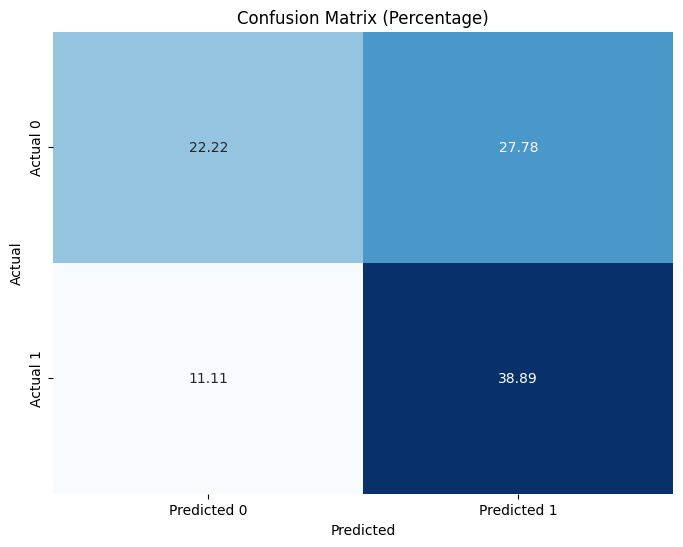

In [25]:
weight = 3.0

# Adjust the input size of the SimpleNN model
input_size = X_train_tsne.shape[1]  # Number of components after LDA
model = SimpleNN(input_size=input_size, hidden_size1=20, hidden_size2=10, hidden_size3=2, output_size=1)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([weight])) 

optimizer = optim.Adam(model.parameters(), lr=0.04910009)  # Add weight decay for L2 regularization

# Learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.4)
EPOCHS = 15
# Training function
# Modify the train function to work with the pipeline
def train(train_loader, val_loader, criterion, optimizer, model, epochs=EPOCHS):
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total_samples = 0
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            inputs, labels = batch
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Compute training accuracy
            predicted = torch.round(outputs)
            correct += (predicted == labels.unsqueeze(1)).sum().item()
            total_samples += labels.size(0)

        accuracy = correct / total_samples
        print(f"Training Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}, Accuracy: {accuracy}%")

        validation(model, val_loader, criterion, epoch)


# Evaluate function for validation
def validation(model, val_loader, criterion, epoch):
    model.eval()
    total_loss = 0
    correct = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            total_loss += loss.item()
            predicted = torch.round(outputs)
            correct += (predicted == labels.unsqueeze(1)).sum().item()
            total_samples += labels.size(0)
    accuracy = correct / total_samples
    print(f"Validation Epoch {epoch+1}, Val Loss: {total_loss / len(val_loader)}, Val Accuracy: {accuracy}")

# Evaluate function for testing
# Update the test function
def test(model, test_loader, criterion, threshold=0.5):
    model.eval()
    total_loss = 0
    correct = 0
    total_samples = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            total_loss += loss.item()

            # Convert probability outputs to binary predictions using the threshold
            predicted = (outputs >= threshold).float()

            correct += (predicted == labels.unsqueeze(1)).sum().item()
            total_samples += labels.size(0)
            
            # Store labels and predictions for confusion matrix
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = correct / total_samples
    conf_matrix = confusion_matrix(all_labels, np.round(all_predictions))
    # Calculate evaluation metrics
    precision = precision_score(all_labels, np.round(all_predictions), zero_division=1)
    recall = recall_score(all_labels, np.round(all_predictions))

    
   # Print the evaluation metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    
    print
    # Plot confusion matrix using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix / total_samples * 100, annot=True, fmt='.2f', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix (Percentage)')
    plt.show()


# Training loop
train(train_loader, val_loader, criterion, optimizer, model, epochs=EPOCHS)

# Testing
test(model, test_loader, criterion, threshold=0.5)

Epoch [10/300], Loss: 1.2947
Epoch [20/300], Loss: 0.9145
Epoch [30/300], Loss: 0.7384
Epoch [40/300], Loss: 0.6643
Epoch [50/300], Loss: 0.6264
Epoch [60/300], Loss: 0.6041
Epoch [70/300], Loss: 0.5899
Epoch [80/300], Loss: 0.5806
Epoch [90/300], Loss: 0.5741
Epoch [100/300], Loss: 0.5696
Epoch [110/300], Loss: 0.5663
Epoch [120/300], Loss: 0.5638
Epoch [130/300], Loss: 0.5619
Epoch [140/300], Loss: 0.5604
Epoch [150/300], Loss: 0.5593
Epoch [160/300], Loss: 0.5583
Epoch [170/300], Loss: 0.5575
Epoch [180/300], Loss: 0.5569
Epoch [190/300], Loss: 0.5563
Epoch [200/300], Loss: 0.5558
Epoch [210/300], Loss: 0.5554
Epoch [220/300], Loss: 0.5550
Epoch [230/300], Loss: 0.5546
Epoch [240/300], Loss: 0.5543
Epoch [250/300], Loss: 0.5539
Epoch [260/300], Loss: 0.5536
Epoch [270/300], Loss: 0.5533
Epoch [280/300], Loss: 0.5531
Epoch [290/300], Loss: 0.5528
Epoch [300/300], Loss: 0.5526
Accuracy: 0.6111
Precision: 0.6000
Recall: 0.6667


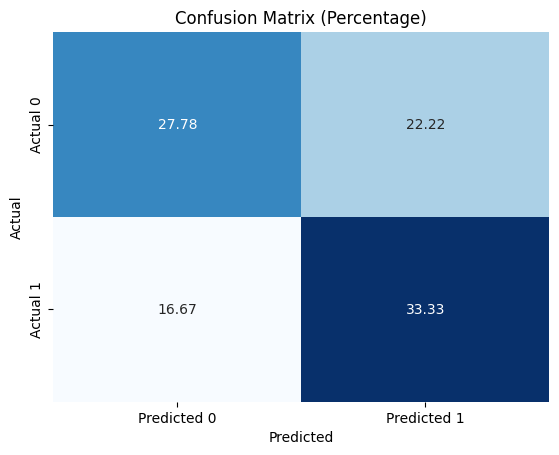

In [14]:
# Linear Regression

# Assuming input_size is the number of features in your dataset
input_size = X_train_tensor.shape[1]

# Define a simple logistic regression model
linear_model = nn.Linear(input_size, 1)
sigmoid = nn.Sigmoid()

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy Loss for binary classification
optimizer = optim.SGD(linear_model.parameters(), lr=.0065)  # Set a fixed learning rate

# Training loop
epochs = 300
for epoch in range(epochs):
    # Forward pass
    outputs = linear_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor.unsqueeze(1))  # Ensure the shape matches

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

# After training, you can use the trained model to make predictions on the test set
test_predictions = sigmoid(linear_model(X_test_tensor))

# Convert probabilities to class labels (0 or 1)
predicted_labels = (test_predictions >= 0.50).int()

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_tensor.numpy().astype(int), predicted_labels.detach().numpy())
precision = precision_score(y_test_tensor.numpy().astype(int), predicted_labels.detach().numpy(), zero_division=1)
recall = recall_score(y_test_tensor.numpy().astype(int), predicted_labels.detach().numpy())

# Print or use the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

# Create confusion matrix for the test set
conf_matrix = confusion_matrix(y_test_tensor.numpy(), predicted_labels.detach().numpy())

# Plot the confusion matrix using seaborn with percentages
total_samples = len(y_test_tensor)
sns.heatmap(conf_matrix / total_samples * 100, annot=True, fmt='.2f', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Percentage)')
plt.show()


Best Parameters: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 114, 'subsample': 1.0}
Validation Accuracy: 0.3889
Validation Precision: 0.3857
Validation Recall: 0.9643
Test Accuracy: 0.5000
Test Precision: 0.5000
Test Recall: 1.0000


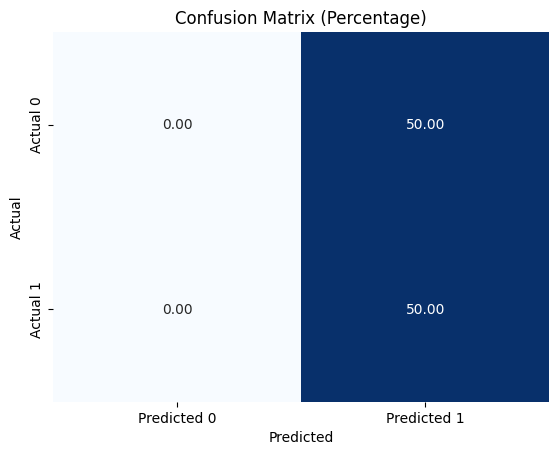

In [31]:
# XGBoost

# Convert data to NumPy arrays for XGBoost
X_train_numpy = X_train_tensor.numpy()
y_train_numpy = y_train_tensor.numpy()

X_val_numpy = X_val_tensor.numpy()
y_val_numpy = y_val_tensor.numpy()

X_test_numpy = X_test_tensor.numpy()
y_test_numpy = y_test_tensor.numpy()

param_grid = {
    'learning_rate': [ 0.30, 0.40, 0.50,0.60], #
    'max_depth': [2 ,3, 4, 5 ,6], # -
    'n_estimators': [114 ,116], #
    'subsample': [0.8, 0.9, 1.0], #
}

# Create XGBoost classifier
xgb_classifier = XGBClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the model to the training data
grid_search.fit(X_train_numpy, y_train_numpy)

# Fit the model to the training data using the best parameters
best_xgb_classifier = grid_search.best_estimator_
best_xgb_classifier.fit(X_train_numpy, y_train_numpy)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Use the best model to make predictions on the validation set
val_predictions = best_xgb_classifier.predict(X_val_numpy)

# Calculate metrics on the validation set
val_accuracy = accuracy_score(y_val_numpy, val_predictions)
val_precision = precision_score(y_val_numpy, val_predictions)
val_recall = recall_score(y_val_numpy, val_predictions)

print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Validation Precision: {val_precision:.4f}')
print(f'Validation Recall: {val_recall:.4f}')

# Use the best model to make predictions on the test set
test_predictions = best_xgb_classifier.predict(X_test_numpy)

# Calculate metrics on the test set
test_accuracy = accuracy_score(y_test_numpy, test_predictions)
test_precision = precision_score(y_test_numpy, test_predictions)
test_recall = recall_score(y_test_numpy, test_predictions)

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')

# Create confusion matrix for the test set
conf_matrix_XG = confusion_matrix(y_test_numpy, test_predictions)

# Plot the confusion matrix using seaborn with percentages
total_samples = len(y_test_tensor)
sns.heatmap(conf_matrix_XG / total_samples * 100, annot=True, fmt='.2f', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Percentage)')
plt.show()

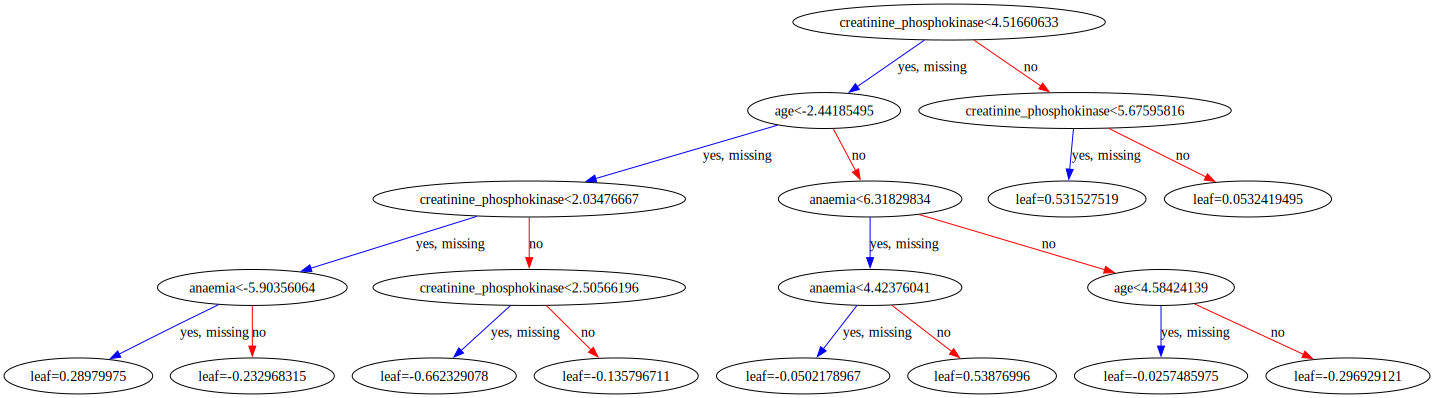

In [16]:

tree_index = 10

# Get the DOT data for the chosen tree with feature names
dot_data = xgb.to_graphviz(best_xgb_classifier, num_trees=tree_index, feature_names=features).source

# Replace the default feature names in the DOT data
for feature_name in features:
    dot_data = dot_data.replace(f'f{features.get_loc(feature_name)}', feature_name)

# Display the decision tree directly in the notebook
Source(dot_data)

In [17]:
# SVM
# Define the parameter grid
param_grid = {'C': [ 3,4,5], 'gamma': [0.1,0.2, 0.25,.001], 'kernel': ['linear', 'poly', 'sigmoid']}

# Initialize SVM classifier
svm_classifier = SVC(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, cv=10, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train_tsne, y_train)

# Get the best parameters
best_params = grid_search.best_params_

print(f'Best Parameters: {best_params}')

# Use the best model for predictions
best_svm_classifier = grid_search.best_estimator_
y_pred = best_svm_classifier.predict(X_test_tsne)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_numpy, y_pred)
precision = precision_score(y_test_numpy, y_pred, zero_division=1)
recall = recall_score(y_test_numpy, y_pred)

# Output the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

conf_matrix_SVM = confusion_matrix(y_test_numpy, y_pred)




Best Parameters: {'C': 4, 'gamma': 0.2, 'kernel': 'poly'}
Accuracy: 0.6111
Precision: 0.6250
Recall: 0.5556


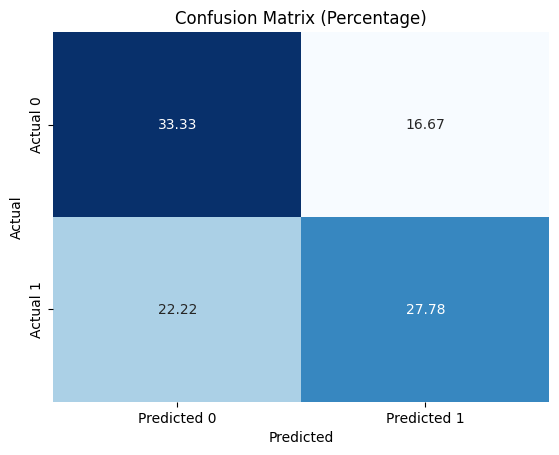

In [18]:
# Plot confusion matrix using seaborn
# conf_matrix_percentage = conf_matrix / len(y_test) * 100

sns.heatmap(conf_matrix_SVM / len(y_test_numpy) * 100, annot=True, fmt='.2f', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Percentage)')
plt.show()